As part of experiment 1, this notebook crops the data of a certain task according to the segmentations created by a low resolution model.

In [1]:
import os
import sys
import nibabel as nib
import shutil
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util import data
from util import visualisation as visu
from util import management as mana
from util import constants as con

###### ZELF INVULLEN
task = con.TASK_510
config = con.CONFIG_LOW

Set some general variables.

In [2]:
# get automatic mappings
thesis_path = con.THESIS_PATH
newTask = con.CROP_TASK_MAPPING[task]
modality = con.MODALITY_MAPPING[task]

# old task
data_path = f"{thesis_path}/Data/nnUNet_raw_data_base/nnUNet_raw_data/Task{task}"
img_tr_path = f'{data_path}/imagesTr'
img_ts_path = f'{data_path}/imagesTs'
label_tr_path = f'{data_path}/labelsTr'
label_ts_path = f'{data_path}/labelsTs'
segmentation_tr_path = f"{thesis_path}/Results/{task}/{config}/inference/{task}/imagesTr"
segmentation_ts_path = f"{thesis_path}/Results/{task}/{config}/inference/{task}/imagesTs"

# new task
new_data_path = f"{thesis_path}/Data/nnUNet_raw_data_base/nnUNet_raw_data/Task{newTask}"
new_img_tr_path = f'{new_data_path}/imagesTr'
new_img_ts_path = f'{new_data_path}/imagesTs'
new_label_tr_path = f'{new_data_path}/labelsTr'
new_label_ts_path = f'{new_data_path}/labelsTs'

# create new paths if they don't exist
mana.create_maybe_dir(new_data_path)
mana.create_maybe_dir(new_img_tr_path)
mana.create_maybe_dir(new_img_ts_path)
mana.create_maybe_dir(new_label_tr_path)
mana.create_maybe_dir(new_label_ts_path)

All the used functions, from getting data to determining and extracting bounding boxes.

In [3]:
# get dicts of labels, segs, imgs and their niifs information of all data   

def get_data_single(labels, segs, imgs, filename):
    label = labels[filename]
    seg = segs[filename]
    img = imgs[filename]
    return img, label, seg

def calculate_and_save_bounding_box_data(lab, seg):

    # get real minimal bounding box and estimated bounding box
    real_bbox = data.determine_minimal_bounding_box(lab)
    est_bbox = data.determine_minimal_bounding_box(seg)
    real_bboxes[filename] = real_bbox
    est_bboxes[filename] = est_bbox

    # calculate diffs
    minX, minY, minZ, maxX, maxY, maxZ = real_bbox
    seg_minX, seg_minY, seg_minZ, seg_maxX, seg_maxY, seg_maxZ = est_bbox
    diffminX.append(minX - seg_minX)
    diffminY.append(minY - seg_minY)
    diffminZ.append(minZ - seg_minZ)
    diffmaxX.append(maxX - seg_maxX)
    diffmaxY.append(maxY - seg_maxY)
    diffmaxZ.append(maxZ - seg_maxZ)
     
def perform_crop(img, lab, filename):
    # get bounding box data
    bbox = est_bboxes[filename]
    print(bbox)
    bboxMinX = max(0, bbox[0] + addminX)
    bboxMinY = max(0, bbox[1] + addminY)
    bboxMinZ = max(0, bbox[2] + addminZ)
    bboxMaxX = min(img.shape[0], bbox[3] + addmaxX)
    bboxMaxY = min(img.shape[0], bbox[4] + addmaxY)
    bboxMaxZ = min(img.shape[0], bbox[5] + addmaxZ)
    print(bboxMinX, bboxMinY, bboxMinZ, bboxMaxX, bboxMaxY, bboxMaxZ)

    # do the cropping
    crop_img = data.get_bounding_box(img, bboxMinX, bboxMinY, bboxMinZ, bboxMaxX, bboxMaxY, bboxMaxZ)
    crop_lab = data.get_bounding_box(lab, bboxMinX, bboxMinY, bboxMinZ, bboxMaxX, bboxMaxY, bboxMaxZ)

    return crop_img, crop_lab

Get all the data from both the training and testing cases.

In [4]:
tr_filenames, tr_labels, tr_segs, tr_imgs, tr_labels_niffs, tr_img_niffs = data.get_all_data_dictionary(img_tr_path, label_tr_path, modality, segmentation_tr_path)
ts_filenames, ts_labels, ts_segs, ts_imgs, ts_labels_niffs, ts_img_niffs = data.get_all_data_dictionary(img_ts_path, label_ts_path, modality, segmentation_ts_path)

In [5]:
print(tr_filenames[0])
mana.create_filename(tr_filenames[0])

panc_001_0000.nii.gz


'panc_001'

For each training and test case, determine the real bounding box and the bounding box estimated from the segmentation. 

We also save their difference, so we can easily analyse with which margin we need to crop.

In [6]:
# init
diffminX, diffminY, diffminZ, diffmaxX, diffmaxY, diffmaxZ = [], [], [], [], [], []
real_bboxes = {}
est_bboxes = {}

for filename in tr_filenames: 
    # get data
    _, lab, seg = get_data_single(tr_labels, tr_segs, tr_imgs, filename)
    # save the stats
    calculate_and_save_bounding_box_data(lab, seg)

for filename in ts_filenames:
    # get data
    _, lab, seg = get_data_single(ts_labels, ts_segs, ts_imgs, filename)
    # save the stats
    calculate_and_save_bounding_box_data(lab, seg)


Perform analysis on the differences between perfect bounding boxes and estimated bounding boxes.

In [7]:
diffs = np.transpose(np.array([diffminX, diffminY, diffminZ, diffmaxX, diffmaxY, diffmaxZ]))
column_names = ['diffMinX', 'diffMinY', 'diffMinZ', 'diffMaxX', 'diffMaxY', 'diffMaxZ']
df = pd.DataFrame(data = diffs, 
                  index = tr_filenames + ts_filenames,
                  columns = column_names)
df.describe()

,diffMinX,diffMinY,diffMinZ,diffMaxX,diffMaxY,diffMaxZ
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,-2.334520,-1.501779,-0.092527,1.964413,0.722420,0.049822
std,11.316637,7.132984,1.212427,3.862662,1.964278,1.917311
min,-107.000000,-72.000000,-9.000000,-9.000000,-7.000000,-11.000000
25%,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
max,38.000000,31.000000,6.000000,24.000000,14.000000,17.000000


In [8]:
addminX = df["diffMinX"].min()
addminY = df["diffMinY"].min()
addminZ = df["diffMinZ"].min()
addmaxX = df["diffMaxX"].max()
addmaxY = df["diffMaxY"].max()
addmaxZ = df["diffMaxZ"].max()

print(f"For X dimension we add {addminX} and {addmaxX}")
print(f"For Y dimension we add {addminY} and {addmaxY}")
print(f"For Z dimension we add {addminZ} and {addmaxZ}")

For X dimension we add -107 and 24
For Y dimension we add -72 and 14
For Z dimension we add -9 and 17


Perform the cropping on all the training/test images and labels.

(145, 261, 42, 287, 345, 62)
38 189 33 311 359 79


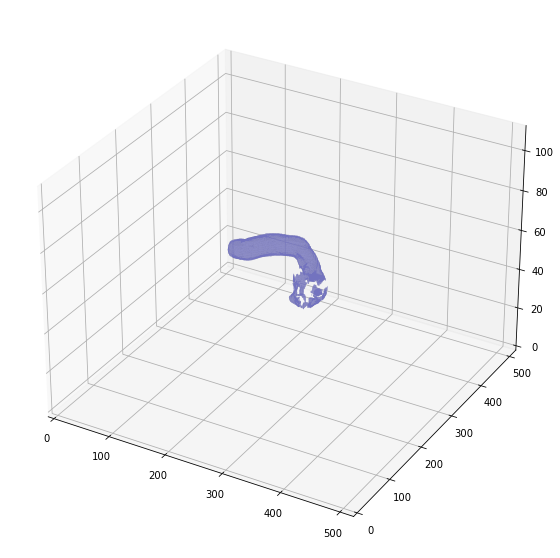

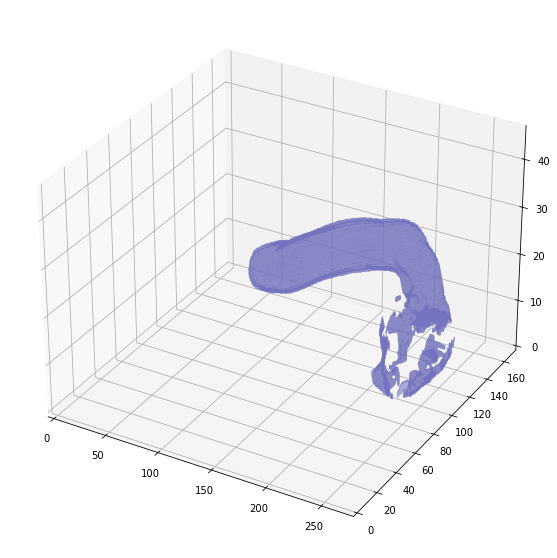

(121, 185, 37, 318, 306, 72)
14 113 28 342 320 89


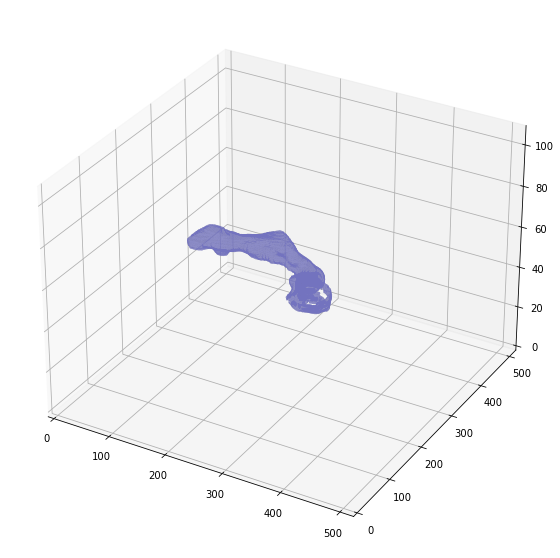

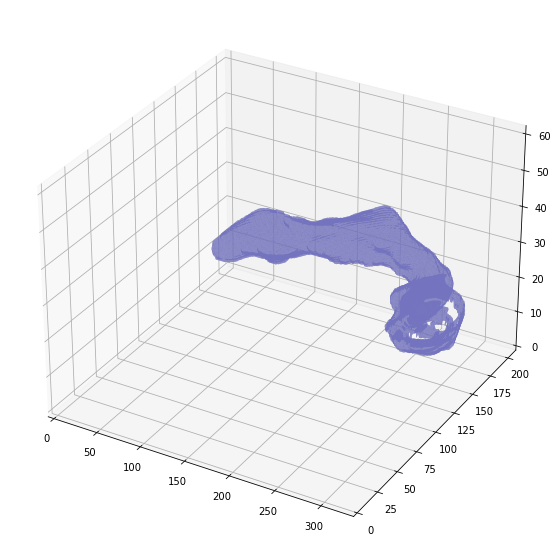

(185, 207, 26, 311, 302, 66)
78 135 17 335 316 83


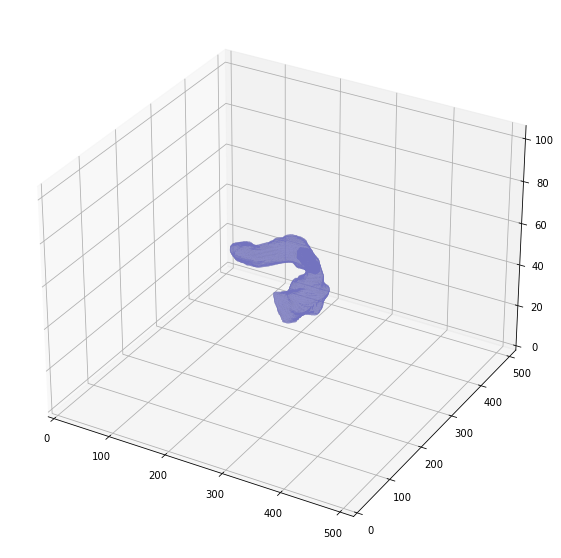

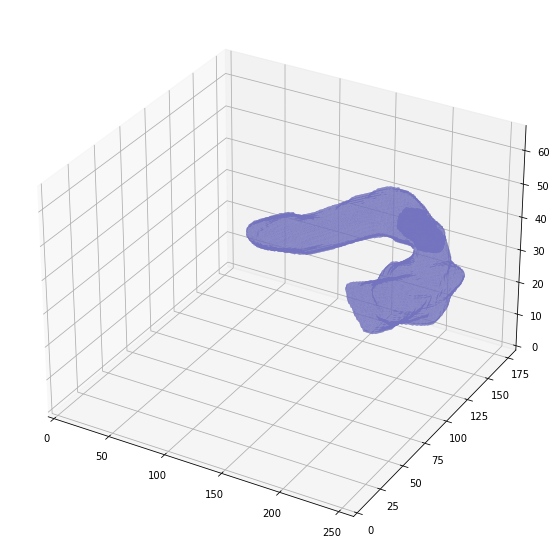

(133, 204, 38, 281, 297, 110)
26 132 29 305 311 127


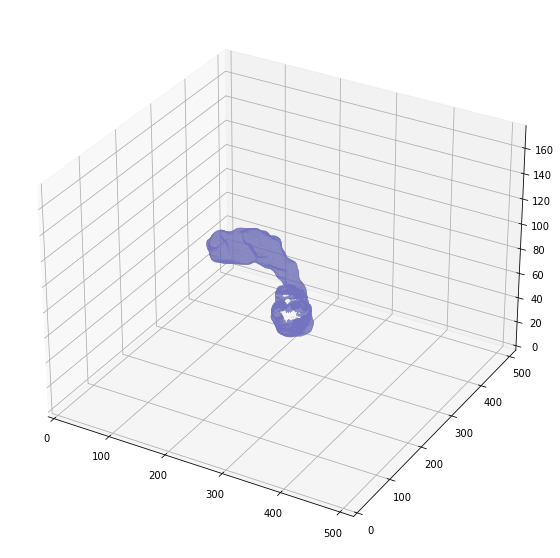

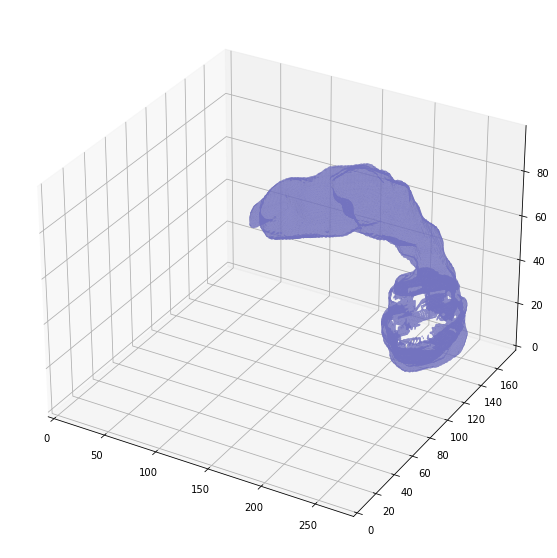

(128, 228, 21, 280, 345, 51)
21 156 12 304 359 68


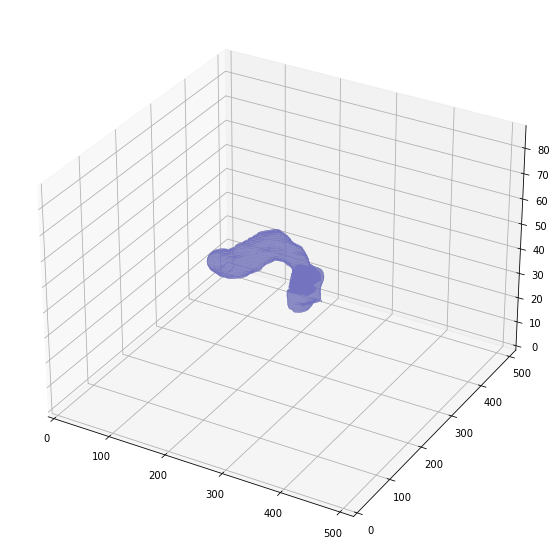

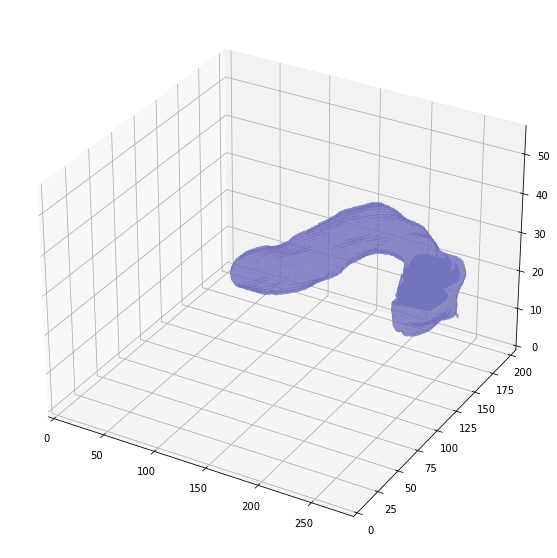

(117, 236, 24, 273, 329, 55)
10 164 15 297 343 72
(159, 211, 28, 298, 314, 60)
52 139 19 322 328 77
(152, 259, 26, 273, 335, 58)
45 187 17 297 349 75
(173, 215, 25, 298, 302, 54)
66 143 16 322 316 71
(191, 256, 31, 342, 336, 62)
84 184 22 366 350 79
(109, 182, 21, 292, 309, 54)
2 110 12 316 323 71
(148, 251, 7, 310, 340, 51)
41 179 0 334 354 68
(115, 205, 22, 310, 329, 62)
8 133 13 334 343 79
(175, 253, 21, 307, 334, 47)
68 181 12 331 348 64
(169, 230, 26, 318, 331, 54)
62 158 17 342 345 71
(110, 253, 7, 293, 373, 30)
3 181 0 317 387 47
(124, 230, 5, 315, 335, 28)
17 158 0 339 349 45
(131, 264, 31, 303, 339, 86)
24 192 22 327 353 103
(133, 231, 5, 315, 324, 26)
26 159 0 339 338 43
(154, 257, 12, 294, 323, 25)
47 185 3 318 337 42
(164, 255, 43, 325, 322, 70)
57 183 34 349 336 87
(120, 212, 20, 311, 357, 61)
13 140 11 335 371 78
(166, 214, 33, 288, 324, 51)
59 142 24 312 338 68
(172, 196, 37, 343, 290, 74)
65 124 28 367 304 91
(85, 205, 27, 341, 333, 55)
0 133 18 365 347 72
(147, 219, 22

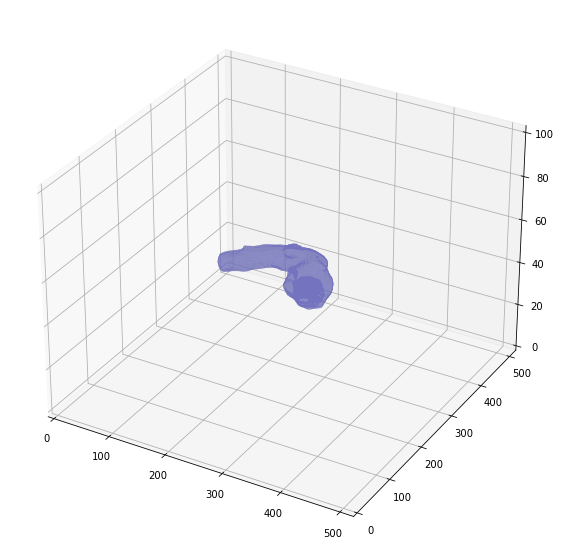

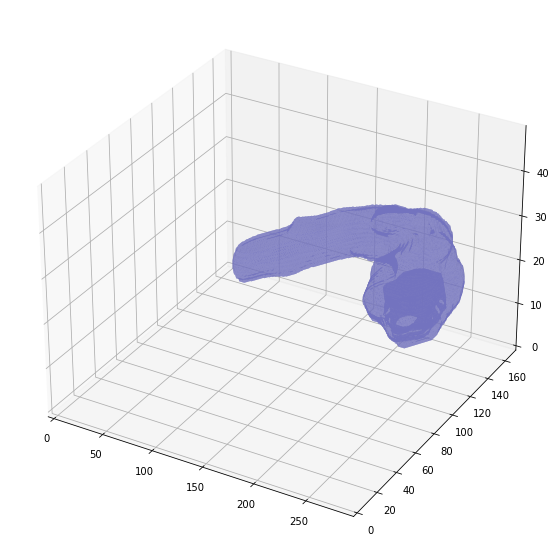

(127, 227, 29, 319, 306, 54)
20 155 20 343 320 71


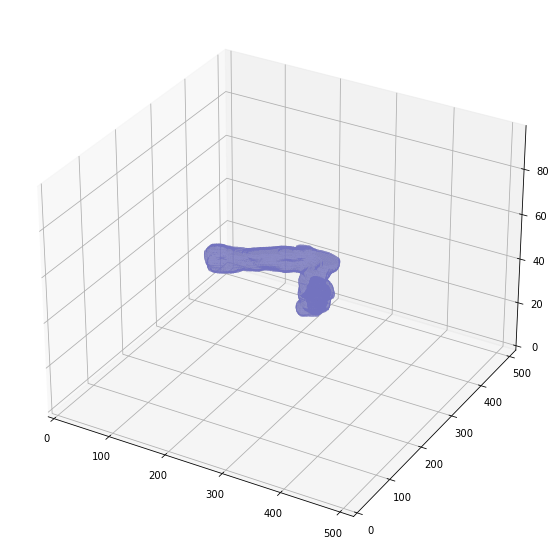

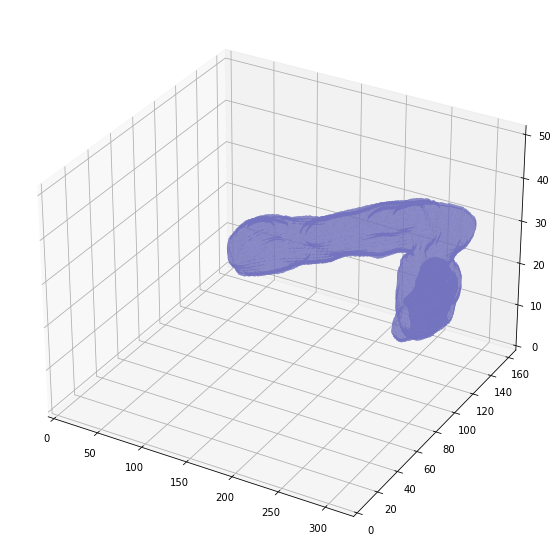

(139, 232, 19, 322, 325, 33)
32 160 10 346 339 50


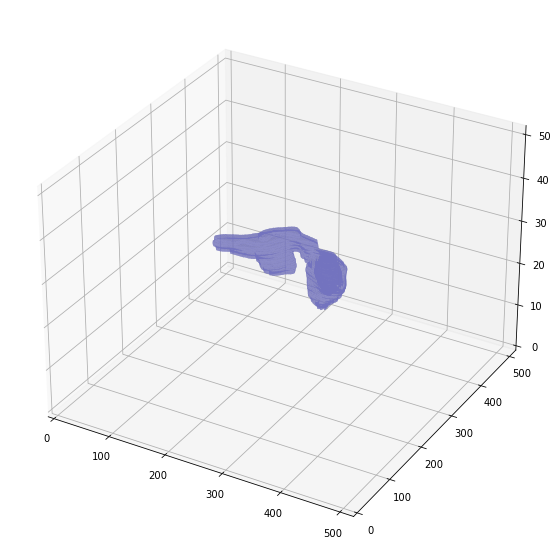

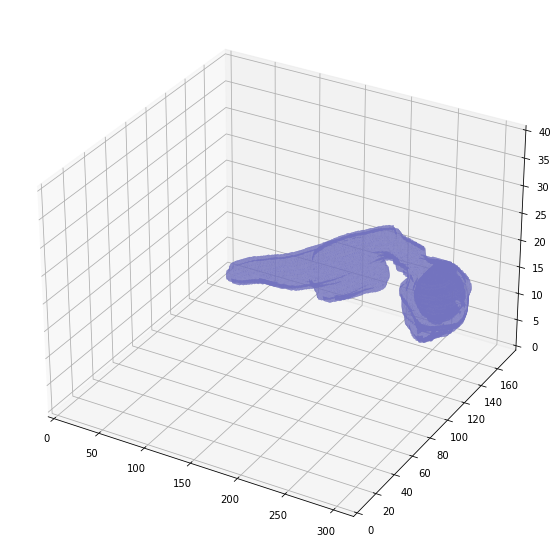

(150, 232, 28, 286, 321, 64)
43 160 19 310 335 81


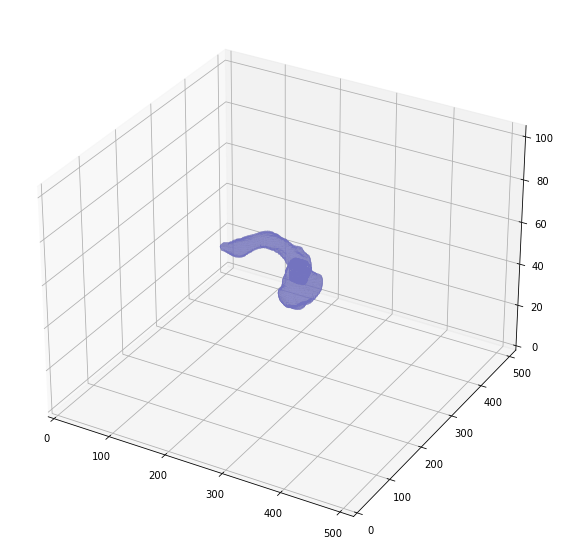

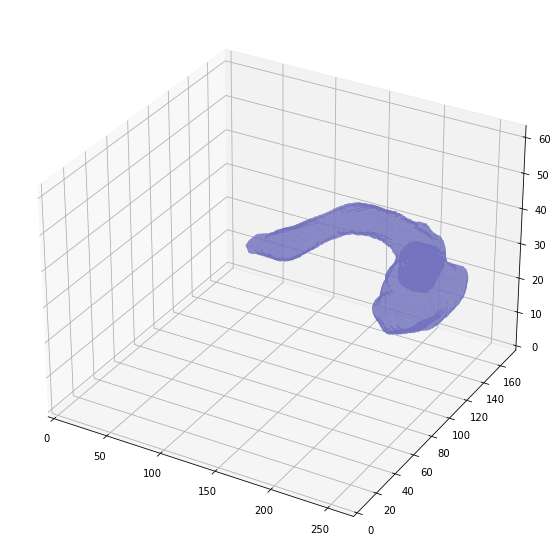

(152, 228, 17, 315, 307, 57)
45 156 8 339 321 74


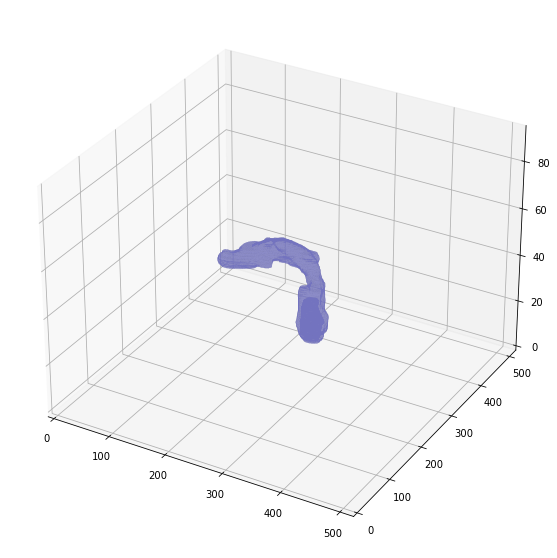

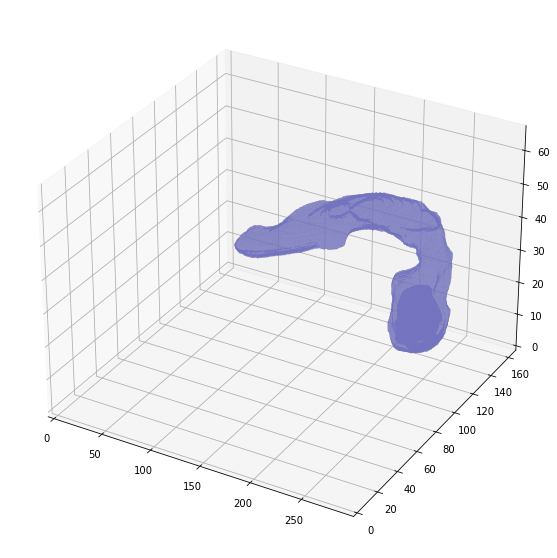

(135, 223, 46, 296, 331, 62)
28 151 37 320 345 79
(134, 228, 2, 254, 311, 22)
27 156 0 278 325 39
(117, 218, 37, 310, 320, 79)
10 146 28 334 334 96
(146, 228, 27, 287, 314, 58)
39 156 18 311 328 75
(125, 248, 55, 322, 340, 70)
18 176 46 346 354 87
(133, 230, 24, 317, 319, 56)
26 158 15 341 333 73
(183, 249, 16, 311, 328, 30)
76 177 7 335 342 47
(130, 205, 37, 296, 318, 69)
23 133 28 320 332 86
(169, 243, 28, 276, 324, 61)
62 171 19 300 338 78
(147, 260, 34, 326, 338, 64)
40 188 25 350 352 81
(145, 208, 13, 309, 338, 34)
38 136 4 333 352 51
(165, 214, 12, 329, 301, 56)
58 142 3 353 315 73
(168, 215, 19, 283, 332, 58)
61 143 10 307 346 75
(163, 232, 26, 301, 314, 53)
56 160 17 325 328 70
(176, 270, 23, 318, 338, 55)
69 198 14 342 352 72
(175, 231, 29, 312, 312, 63)
68 159 20 336 326 80
(121, 204, 32, 320, 321, 65)
14 132 23 344 335 82
(160, 255, 26, 328, 335, 52)
53 183 17 352 349 69
(162, 242, 16, 294, 335, 42)
55 170 7 318 349 59
(194, 284, 24, 304, 344, 60)
87 212 15 328 358 77
(111, 

In [9]:
# crop all training data
for i, filename in enumerate(tr_filenames): 
    # get data
    img, lab, _ = get_data_single(tr_labels, tr_segs, tr_imgs, filename)
    
    # get the cropped data
    crop_img, crop_lab = perform_crop(img, lab, filename)

    # visualise the first 5
    if i < 5:
        visu.plot_3d(lab)
        visu.plot_3d(crop_lab)

    # get the niifti headers
    img_niff = tr_img_niffs[filename]
    label_niff = tr_labels_niffs[filename]

    # create new data
    new_img = nib.Nifti1Image(crop_img, img_niff.affine, img_niff.header)
    new_lab = nib.Nifti1Image(crop_lab, label_niff.affine, label_niff.header)

    # save the data
    label_filename = mana.create_filename(filename) + ".nii.gz"
    nib.save(new_img, os.path.join(new_img_tr_path, filename))
    nib.save(new_lab, os.path.join(new_label_tr_path, label_filename))

# crop all test data
for i, filename in enumerate(ts_filenames): 
    # get data
    img, lab, _ = get_data_single(ts_labels, ts_segs, ts_imgs, filename)
    
    # get the cropped data
    crop_img, crop_lab = perform_crop(img, lab, filename)

    # visualise the first 5
    if i < 5:
        visu.plot_3d(lab)
        visu.plot_3d(crop_lab)

    # get the niifti headers
    img_niff = ts_img_niffs[filename]
    label_niff = ts_labels_niffs[filename]

    # create new data
    new_img = nib.Nifti1Image(crop_img, img_niff.affine, img_niff.header)
    new_lab = nib.Nifti1Image(crop_lab, label_niff.affine, label_niff.header)

    # save the data
    label_filename = mana.create_filename(filename) + ".nii.gz"
    nib.save(new_img, os.path.join(new_img_ts_path, filename))
    nib.save(new_lab, os.path.join(new_label_ts_path, label_filename))


Finally, copy the dataset.json

In [11]:
datasetjson = "dataset.json"
shutil.copy(os.path.join(data_path, datasetjson), os.path.join(new_data_path, datasetjson))

'C:/Users/ikke_/OneDrive/Documenten/Thesis/Data/nnUNet_raw_data_base/nnUNet_raw_data/Task561\\dataset.json'